# Baseline Gender Bias Document Classifiers

* **Supervised learning**
    * Train, Validate, and (Blind) Test Data: under directory `../data/doc_clf_data/model_input`
    * Output: `../data/doc_clf_data/model_output_sgd`, `..data/doc_clf_data/model_output_logistic_regression`
* **Multilabel classification**
    * 1 category of labels:
        1. *Person Name:* Unknown, Non-binary,* Feminine, Masculine

**Note: Annotators did not find data on which to apply this label during the manual annotation process, so it does not appear in the target data.*

***

**Table of Contents**

[Setup](#set)

Baseline Classifiers:

  * [Classifier 1: Logistic Regression (LR)](#log)
  
  * [Classifier 2: Stochastic Gradient Descent (SGD)](#sgd)

  * [Classifier 3: Random Forest (RF)](#ran)
  
[Error Analysis](#err)

[SGD Classification with Data Normalization](#norm)

***

<a id="set"></a>
## Setup

In [1]:
# For custom functions
import utils, config

# For working with data files and directories
import numpy as np
import pandas as pd
from pathlib import Path

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For classification with scikit-learn
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support

Read in the training, validation, (a.k.a. development or devtest) and blind test data:

In [2]:
X_train_path = config.docc_path+"train_docs.txt"
X_devtest_path = config.docc_path+"validate_docs.txt"
y_train_path = config.docc_path+"train_labels.txt"
y_devtest_path = config.docc_path+"validate_labels.txt"

In [3]:
docs_seperator = "\n|\n"
labels_seperator = "\n"

In [4]:
X_train = utils.readData(X_train_path, docs_seperator)
print(X_train[0])
print(len(X_train))

Labelled Apparently some chapters, amounting to about 160 printed pages, of a general book on education projected by my Father around 1930. KEEP, Essays on Teaching, HT 1963, by Hector.
16541


In [5]:
X_devtest = utils.readData(X_devtest_path, docs_seperator)
print(X_devtest[0])
print(len(X_devtest))

Edward Bald Jamieson, from Shetland, was a graduate of Edinburgh University (1900), and then demonstrator and lecturer in Anatomy at Edinburgh University. He was also an author of medical textbooks on Anatomy. William Rolland Scott Cowe was born on 24 October 1915 in Edinburgh. He studied at Edinburgh University and was awarded the degrees of Bachelor of Medicine, and Bachelor of Surgery, MB., Ch.B. on 20 July 1938. Still resident in Edinburgh in 1939, he was Obstetric House Surgeon at the Simpson Memorial Pavilion, Edinburgh Royal Infirmary. His career then took him to Wigan, Lancashire, as House Surgeon at the Royal Infirmary there. In Keighley, Yorkshire, he served as the Police Surgeon, Keighley Division, West Riding Constabulary, and was a Clinical Assistant (Venereology) at Airedale General Hospital.  During the Second World War he served as a Captain and then Major with the Royal Army Medical Corps, serving in Africa and Palestine. Cowe's prime interest was obstetrics and gynaec

In [6]:
y_train = utils.readData(y_train_path, labels_seperator)
print(y_train[:3])
print(len(y_train))

['Unknown, Masculine' 'Masculine' 'Unknown']
16541


In [7]:
y_devtest = utils.readData(y_devtest_path, labels_seperator)
print(y_devtest[:3])
print(len(y_devtest))

['Masculine' 'Unknown, Masculine' 'Masculine']
5514


Convert the data to numeric representations, where:
```
labels = {
    "Unknown": 0, "Feminine": 1, "Masculine": 2
         }
```

In [8]:
labels = {"Unknown": 0, "Feminine": 1, "Masculine": 2}
# Convert the strings of labels to tuples of numbers
y_train_numeric = utils.getNumericLabels(y_train, labels)
y_devtest_numeric = utils.getNumericLabels(y_devtest, labels)
assert len(y_train_numeric) == len(y_train)
assert len(y_devtest_numeric) == len(y_devtest)

In [9]:
print(y_train_numeric[:10])

[(0, 2), (2,), (0,), (0, 2, 1), (0, 2), (), (0, 2), (0, 2), (0, 2), (1,)]


Binarize the data so labels are represented by a 0 (not present) or 1 (present):

In [10]:
# Convert each iterable of iterables above to a multilabel format
mlb = MultiLabelBinarizer()
y_train_binarized = mlb.fit_transform(y_train_numeric)
y_devtest_binarized = mlb.fit_transform(y_devtest_numeric)
print(y_devtest_binarized.shape)
print(y_devtest_binarized[0])

(5514, 3)
[0 0 1]


In [11]:
# # Bag of Words
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# X_test_counts = count_vect.fit_transform(X_test)
# print("Bag of Words:")
# print(X_train_counts.shape)
# print(X_test_counts.shape)

# # Term Frequency times Inverse Document Frequency
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
# print("TFIDF:")
# print(X_train_tfidf.shape)
# print(X_test_tfidf.shape)

In [12]:
# assert X_train_counts.shape[0] == len(y_train_numeric)
# assert X_test_tfidf.shape[0] == len(y_test_numeric)

Create the directory to write the classification models' performance metrics to:

In [13]:
metrics_dir = "./baseline_performance_metrics/"
Path(metrics_dir).mkdir(parents=True, exist_ok=True)

## Baseline Classifiers
<a id="mnb"></a>

<a id="log"></a>
### Classifier 1: Logistic Regression

*a.k.a. maximum-entropy (MaxEnt) or log-linear classification*

In [14]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(LogisticRegression(solver="liblinear", multi_class="ovr")))  # multilabel classification by training one classifier per label
    ])

In [15]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)

### Performance

Calculate performance metrics for the Logistic Regression classifier

In [16]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.9301777294160319


In [17]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_
print(classes, original_classes)

[0 1 2] [0 1 2]


In [18]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)

In [20]:
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes, labels)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,2721,467,1976,350,0.849527,0.808842,0.828685
1,Feminine,5381,104,24,5,0.827586,0.187500,0.305732
2,Masculine,4950,188,335,41,0.890957,0.640535,0.745273


Save the performance results:

In [24]:
df_dev.to_csv(metrics_dir+"LR_PN_dev_performance.csv")

<a id="sgd"></a>
## Classifier 2: Stochastic Gradient Descent

Build a pipeline:

In [76]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(SGDClassifier(loss="hinge")))  # Support Vector Machines loss function
    ])

In [77]:
clf_pipeline.fit(X_train, y_train_binarized)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                             average=False,
                                                             class_weight=None,
                                                             early_stopping=False,
                      

In [78]:
predicted_dev = clf_pipeline.predict(X_devtest)

### Peformance

Calculate performance metrics for the Stochastic Gradient Descent classifier

In [79]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.937371539112562


In [80]:
classes = clf_pipeline.classes_
print(classes)
original_classes = mlb.classes_
print(original_classes)

[0 1 2]
[0 1 2]


Plot a [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix) of the results, where, for class *i*:
* Count of true negatives (TN) is at position *i*,0,0
* Count of false negatives (FN) is at position *i*,1,0
* Count of true positives (FP) is at position *i*,1,1
* Count of false positives (PF) is at position *i*,0,1

In [81]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes, labels)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,2673,365,2078,398,0.839257,0.850594,0.844887
1,Feminine,5374,84,44,12,0.785714,0.343750,0.478261
2,Masculine,4933,119,404,58,0.874459,0.772467,0.820305


This classifier performs better than the LR and RF models.

Save the performance results:

In [33]:
df_dev.to_csv(metrics_dir+"SGD-SVM_PN_dev_performance.csv")

<a id="ran"></a>
### Classifier 3: Random Forest

In [54]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("clf", OneVsRestClassifier(RandomForestClassifier(max_depth=6, random_state=0)))
    ])

In [55]:
clf_pipeline.fit(X_train, y_train_binarized)
predicted_dev = clf_pipeline.predict(X_devtest)

In [56]:
classes = clf_pipeline.classes_
original_classes = mlb.classes_

In [57]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.8180993833877402


In [58]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes, labels)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,3063,2370,73,8,0.901235,0.029881,0.057845
1,Feminine,5386,128,0,0,0.000000,0.000000,0.000000
2,Masculine,4991,503,20,0,1.000000,0.038241,0.073665


In [59]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)

This classifier performs the worst out of the three (by far!).  

Save the performance results: 

In [61]:
df_dev.to_csv(metrics_dir+"RF_PN_dev_performance.csv")

<a id="err"></a>
## Error Analysis

Error analysis of the **SGD classifier**, as this is the top-performing baseline classification model.

In [88]:
# Associate classes to numeric labels to strings of label names
label_class_to_no = dict(zip(classes,original_classes))
label_no_to_name = dict(zip(list(labels.values()), list(labels.keys())))
print(labels)
print(label_class_to_no)
print(label_no_to_name)

{'Unknown': 0, 'Feminine': 1, 'Masculine': 2}
{0: 0, 1: 1, 2: 2}
{0: 'Unknown', 1: 'Feminine', 2: 'Masculine'}


#### Dev Data Confusion Matrices

In [83]:
matrices = dict()  # keys are labels, values are 2D arrays 
for col in range(len(classes)):
    y_test_label = y_devtest_binarized[:, col]
    pred_label = predicted_dev[:, col]
    
    matrices[classes[col]] = confusion_matrix(pred_label, y_test_label, normalize="all")

In [84]:
png_dir = metrics_dir+"sgd_pn_dev_confusion_matrices/"
Path(png_dir).mkdir(parents=True, exist_ok=True)

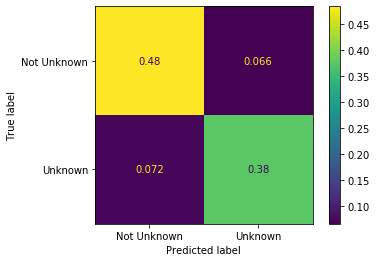

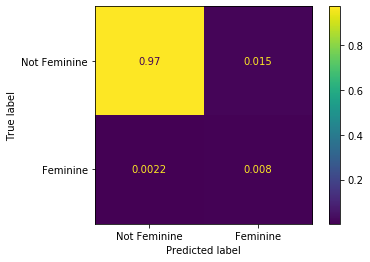

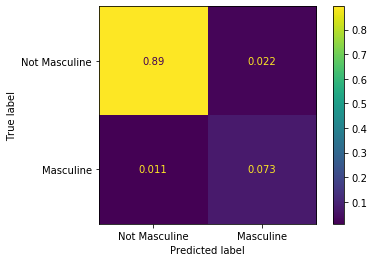

In [89]:
for label_class,matrix in matrices.items():
    label_name = label_no_to_name[label_class_to_no[label_class]]
    filename = "{}_cmatrix_normalized_all.png".format(label_name)
    ConfusionMatrixDisplay(matrix, display_labels=["Not "+label_name,label_name]).plot()
    plt.savefig(png_dir+filename)

Convert predicted dev labels back to text:

In [90]:
predicted_dev[0]

array([1, 0, 1])

In [91]:
pred_dev_numeric_labels = mlb.inverse_transform(predicted_dev)
pred_dev_numeric_labels[0]

(0, 2)

In [93]:
inverse_labels = dict(zip(list(labels.values()), list(labels.keys())))
# print(inverse_labels)
pred_dev_labels = []
for number_list in pred_dev_numeric_labels:
    label_list = [inverse_labels[n] for n in number_list]
    pred_dev_labels += [label_list]
    
assert(len(pred_dev_labels) == len(pred_dev_numeric_labels))
assert(len(pred_dev_labels) == len(predicted_dev))

Add the classifier's labels to the `aggregated_validate.csv` DataFrame of descriptions to facilitate error analysis:

In [95]:
df_dev = pd.read_csv(config.docc_path+"splits_as_csv/aggregated_final_validate.csv", index_col=0)
df_dev.head()

,description_id,start_offset,end_offset,field,description,agg_ann_id,subset,label
5523,5523,367,1965,Biographical / Historical,"Edward Bald Jamieson, from Shetland, was a gra...","[2571, 2572, 2573, 2574, 21607, 21608]",dev,{'Masculine'}
4719,4719,5650,5811,Biographical / Historical,This likely refers to an article of the same t...,"[18486, 18487, 25469]",dev,"{'Unknown', 'Masculine'}"
735,735,7735,7881,Biographical / Historical,John Baillie kept a collection of the prayers ...,[13039],dev,{'Masculine'}
2183,2183,1072,1372,Biographical / Historical,Joseph W. Hills graduated with the degree of M...,[5314],dev,{'Masculine'}
2299,2299,546,3642,Biographical / Historical,This collection is composed simply of an invit...,"[8577, 8578, 8579, 8580, 8581, 8583, 8584, 858...",dev,"{'Unknown', 'Masculine', 'Feminine'}"


In [96]:
df_dev = df_dev.rename(columns={"label":"manual_label"})

In [97]:
df_dev.insert(len(df_dev.columns), "sgd_label", pred_dev_labels)
df_dev.head()

,description_id,start_offset,end_offset,field,description,agg_ann_id,subset,manual_label,sgd_label
5523,5523,367,1965,Biographical / Historical,"Edward Bald Jamieson, from Shetland, was a gra...","[2571, 2572, 2573, 2574, 21607, 21608]",dev,{'Masculine'},"[Unknown, Masculine]"
4719,4719,5650,5811,Biographical / Historical,This likely refers to an article of the same t...,"[18486, 18487, 25469]",dev,"{'Unknown', 'Masculine'}","[Unknown, Masculine]"
735,735,7735,7881,Biographical / Historical,John Baillie kept a collection of the prayers ...,[13039],dev,{'Masculine'},"[Unknown, Masculine]"
2183,2183,1072,1372,Biographical / Historical,Joseph W. Hills graduated with the degree of M...,[5314],dev,{'Masculine'},[]
2299,2299,546,3642,Biographical / Historical,This collection is composed simply of an invit...,"[8577, 8578, 8579, 8580, 8581, 8583, 8584, 858...",dev,"{'Unknown', 'Masculine', 'Feminine'}","[Unknown, Masculine]"


Save this version of the data:

In [98]:
validate_output_path = "../data/doc_clf_data/model_output_sgd/"
Path(validate_output_path).mkdir(parents=True, exist_ok=True)
df_dev.to_csv(validate_output_path+"aggregated_final_validate_predictions_sgd_pn.csv")

Explode and join the DataFrames of expected and predicted annotations for easier row-by-row comparison:

In [99]:
df_exp = pd.read_csv(config.docc_path+"splits_as_csv/aggregated_final_validate.csv", index_col=0)
# Rows without labels can't be exploded, so remove those and concatenate them at the end
df_exp_na = df_exp.loc[df_exp.label.isna()]
df_exp_notna = df_exp.loc[~df_exp.label.isna()]

labels_lists = df_exp_notna["label"] 
new_labels_lists = [label_list[2:-2] for label_list in labels_lists if label_list != ""]
df_exp_notna = df_exp_notna.drop(columns=["label"])
df_exp_notna.insert(len(df_exp_notna.columns), "label", new_labels_lists)
df_exp_notna = df_exp_notna.assign(label=df_exp_notna.label.str.split("', '")).explode("label")

df_exp = pd.concat([df_exp_na,df_exp_notna])
df_exp = df_exp.sort_values(by="description_id")
df_exp = df_exp.rename(columns={"label":"expected_label"})
df_exp = df_exp.fillna("None")

df_exp.head()

,description_id,start_offset,end_offset,field,description,agg_ann_id,subset,expected_label
5,5,17,60,Title,Papers of Rev Tom Allan (1916-1965),"[9531, 23084]",dev,Unknown
5,5,17,60,Title,Papers of Rev Tom Allan (1916-1965),"[9531, 23084]",dev,Masculine
6,6,61,560,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",None,dev,None
7,7,561,2513,Biographical / Historical,Rev Thomas Allan was born on 16 August 1916 in...,"[55, 9526, 9527, 9528, 9529, 9530, 9532, 9533,...",dev,Feminine
7,7,561,2513,Biographical / Historical,Rev Thomas Allan was born on 16 August 1916 in...,"[55, 9526, 9527, 9528, 9529, 9530, 9532, 9533,...",dev,Unknown


In [116]:
df_pred = pd.read_csv(validate_output_path+"aggregated_final_validate_predictions_sgd_pn.csv", index_col=0)
df_pred = df_pred.drop(columns=["manual_label"])
df_pred = df_pred.rename(columns={"sgd_label":"predicted_label"})
df_pred["predicted_label"] = [label_list[2:-2] for label_list in list(df_pred.predicted_label)]
df_pred = df_pred.assign(predicted_label=df_pred.predicted_label.str.split("', '")).explode("predicted_label")
df_pred.head()

,description_id,start_offset,end_offset,field,description,agg_ann_id,subset,predicted_label
5,5,17,60,Title,Papers of Rev Tom Allan (1916-1965),"[9531, 23084]",dev,Unknown
6,6,61,560,Scope and Contents,"Sermons and addresses, 1947-1963; essays and l...",NaN,dev,
7,7,561,2513,Biographical / Historical,Rev Thomas Allan was born on 16 August 1916 in...,"[55, 9526, 9527, 9528, 9529, 9530, 9532, 9533,...",dev,Unknown
7,7,561,2513,Biographical / Historical,Rev Thomas Allan was born on 16 August 1916 in...,"[55, 9526, 9527, 9528, 9529, 9530, 9532, 9533,...",dev,Masculine
10,10,77,417,Scope and Contents,"Academic papers, 1942-1986; publications and a...",NaN,dev,


In [118]:
df_pred_sub = df_pred.drop(columns=["description",  "field", "start_offset", "end_offset", "subset"])
df_pred_sub.to_csv(config.docc_path+"../model_output_sgd/sgd_pn_validate_predictions_exploded.csv")

In [108]:
dfs = pd.merge(
    left=df_exp, right=df_pred, 
    how="outer", 
    left_on=["description_id","start_offset","end_offset","description","expected_label"], 
    right_on=["description_id","start_offset","end_offset","description","predicted_label"], 
    suffixes=["", "_pred"],
    indicator=True
)
dfs = dfs[["description_id","start_offset","end_offset","description","expected_label","predicted_label","_merge"]]
dfs.head()

,description_id,start_offset,end_offset,description,expected_label,predicted_label,_merge
0,5,17,60,Papers of Rev Tom Allan (1916-1965),Unknown,Unknown,both
1,5,17,60,Papers of Rev Tom Allan (1916-1965),Masculine,NaN,left_only
2,6,61,560,"Sermons and addresses, 1947-1963; essays and l...",None,NaN,left_only
3,7,561,2513,Rev Thomas Allan was born on 16 August 1916 in...,Feminine,NaN,left_only
4,7,561,2513,Rev Thomas Allan was born on 16 August 1916 in...,Unknown,Unknown,both


In [109]:
dfs.replace(to_replace="left_only", value="false negative", inplace=True)
dfs.replace(to_replace="right_only", value="false positive", inplace=True)
dfs.replace(to_replace="both", value="true positive", inplace=True)
dfs.head()

,description_id,start_offset,end_offset,description,expected_label,predicted_label,_merge
0,5,17,60,Papers of Rev Tom Allan (1916-1965),Unknown,Unknown,true positive
1,5,17,60,Papers of Rev Tom Allan (1916-1965),Masculine,NaN,false negative
2,6,61,560,"Sermons and addresses, 1947-1963; essays and l...",None,NaN,false negative
3,7,561,2513,Rev Thomas Allan was born on 16 August 1916 in...,Feminine,NaN,false negative
4,7,561,2513,Rev Thomas Allan was born on 16 August 1916 in...,Unknown,Unknown,true positive


In [110]:
df_grouped = dfs.set_index(["description_id", "start_offset","end_offset","description","_merge"])
df_sorted = df_grouped.sort_values(by=["description_id","start_offset","_merge"], ascending=True)
df_sorted.head()

expected_label  \
description_id start_offset end_offset description                                        _merge                          
5              17           60         Papers of Rev Tom Allan (1916-1965)                false negative      Masculine   
                                                                                          true positive         Unknown   
6              61           560        Sermons and addresses, 1947-1963; essays and le... false negative           None   
                                                                                          false positive            NaN   
7              561          2513       Rev Thomas Allan was born on 16 August 1916 in ... false negative       Feminine   

                                                                                                         predicted_label  
description_id start_offset end_offset description                                        _merge                          
5              17           60         Papers of Rev Tom Allan (1916-1965)                false negative             NaN  
                                                                                          true positive          Unknown  
6              61           560        Sermons and addresses, 1947-1963; essays and le... false negative             NaN  
                                                                                          false positive                  
7              561          2513       Rev Thomas Allan was born on 16 August 1916 in ... false negative             NaN

In [111]:
df_sorted.to_csv(validate_output_path+"sgd_pn_error_analysis.csv")

<a id="norm"></a>
## SGD Classification with Data Normalization

Build a pipeline:

In [129]:
clf_pipeline = Pipeline([
    ("vect", CountVectorizer()),
    ("tfidf", TfidfTransformer()),
    ("scaler", StandardScaler(with_mean=False)),               # input is sparse, so cannot center mean at 0
    ("clf", OneVsRestClassifier(SGDClassifier(loss="hinge")))  # Support Vector Machines loss function
    ])

In [130]:
clf_pipeline.fit(X_train, y_train_binarized)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001,
                                                             average=False,
                                                             class_weight=None,
                                                             early_stopping=False,
                      

In [131]:
predicted_dev = clf_pipeline.predict(X_devtest)

### Peformance

Calculate performance metrics for the Stochastic Gradient Descent classifier

In [132]:
print("Dev Test Accuracy:", np.mean(predicted_dev == y_devtest_binarized))

Dev Test Accuracy: 0.8723249909321726


In [133]:
classes = clf_pipeline.classes_
print(classes)
original_classes = mlb.classes_
print(original_classes)

[0 1 2]
[0 1 2]


Plot a [confusion matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-confusion-matrix) of the results, where, for class *i*:
* Count of true negatives (TN) is at position *i*,0,0
* Count of false negatives (FN) is at position *i*,1,0
* Count of true positives (FP) is at position *i*,1,1
* Count of false positives (PF) is at position *i*,0,1

In [134]:
dev_matrix = multilabel_confusion_matrix(y_devtest_binarized, predicted_dev, labels=classes)
df_dev = utils.getPerformanceMetrics(y_devtest_binarized, predicted_dev, dev_matrix, classes, original_classes, labels)
df_dev

,labels,true_neg,false_neg,true_pos,false_pos,precision,recall,f_1
0,Unknown,2405,552,1891,666,0.739539,0.774048,0.756400
1,Feminine,5138,69,59,248,0.192182,0.460938,0.271264
2,Masculine,4594,180,343,397,0.463514,0.655832,0.543151


Thd classifier performed worse on the normalized data than it did on the unnormalized data.

Save the performance results:

In [135]:
df_dev.to_csv(metrics_dir+"SGD-SVM_PNnormalized_dev_performance.csv")